## Data 
To better mimic the problem that we have, we are going to create a single sequence of moving numbers from the MNIST dataset. We then split the sequence into smaller ones. 

### Create movie

In [30]:
import math
import os
import sys

import numpy as np
from PIL import Image


###########################################################################################
# script to generate moving mnist video dataset (frame by frame) as described in
# [1] arXiv:1502.04681 - Unsupervised Learning of Video Representations Using LSTMs
#     Srivastava et al
# by Tencia Lee
# saves in hdf5, npz, or jpg (individual frames) format
###########################################################################################

# helper functions
def arr_from_img(im, mean=0, std=1):
    '''
    Args:
        im: Image
        shift: Mean to subtract
        std: Standard Deviation to subtract
    Returns:
        Image in np.float32 format, in width height channel format. With values in range 0,1
        Shift means subtract by certain value. Could be used for mean subtraction.
    '''
    width, height = im.size
    arr = im.getdata()
    c = int(np.product(arr.size) / (width * height))

    return (np.asarray(arr, dtype=np.float32).reshape((height, width, c)).transpose(2, 1, 0) / 255. - mean) / std


def get_image_from_array(X, index, mean=0, std=1):
    '''
    Args:
        X: Dataset of shape N x C x W x H
        index: Index of image we want to fetch
        mean: Mean to add
        std: Standard Deviation to add
    Returns:
        Image with dimensions H x W x C or H x W if it's a single channel image
    '''
    ch, w, h = X.shape[1], X.shape[2], X.shape[3]
    ret = (((X[index] + mean) * 255.) * std).reshape(ch, w, h).transpose(2, 1, 0).clip(0, 255).astype(np.uint8)
    if ch == 1:
        ret = ret.reshape(h, w)
    return ret


# loads mnist from web on demand
def load_dataset(training=True):
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    import gzip
    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        data = data.reshape(-1, 1, 28, 28).transpose(0, 1, 3, 2)
        return data / np.float32(255)

    if training:
        return load_mnist_images('train-images-idx3-ubyte.gz')
    return load_mnist_images('t10k-images-idx3-ubyte.gz')


def generate_moving_mnist(training, shape=(64, 64), num_frames=10000, num_images=1, original_size=28, nums_per_image=2):
    '''
    Args:
        training: Boolean, used to decide if downloading/generating train set or test set
        shape: Shape we want for our moving images (new_width and new_height)
        num_frames: Number of frames in a particular movement/animation/gif
        num_images: Number of movement/animations/gif to generate
        original_size: Real size of the images (eg: MNIST is 28x28)
        nums_per_image: Digits per movement/animation/gif.
    Returns:
        Dataset of np.uint8 type with dimensions num_frames * num_images x 1 x new_width x new_height
    '''
    mnist = load_dataset(training)
    width, height = shape

    # Get how many pixels can we move around a single image
    lims = (x_lim, y_lim) = width - original_size, height - original_size

    # Create a dataset of shape of num_frames * num_images x 1 x new_width x new_height
    # Eg : 3000000 x 1 x 64 x 64
    dataset = np.empty((num_frames * num_images, 1, width, height), dtype=np.uint8)

    for img_idx in range(num_images):
        # Randomly generate direction, speed and velocity for both images
        direcs = np.pi * (np.random.rand(nums_per_image) * 2 - 1)
        speeds = np.random.randint(5, size=nums_per_image) + 2
        veloc = np.asarray([(speed * math.cos(direc), speed * math.sin(direc)) for direc, speed in zip(direcs, speeds)])
        # Get a list containing two PIL images randomly sampled from the database
        mnist_images = [Image.fromarray(get_image_from_array(mnist, r, mean=0)).resize((original_size, original_size),
                                                                                       Image.ANTIALIAS) \
                        for r in np.random.randint(0, mnist.shape[0], nums_per_image)]
        # Generate tuples of (x,y) i.e initial positions for nums_per_image (default : 2)
        positions = np.asarray([(np.random.rand() * x_lim, np.random.rand() * y_lim) for _ in range(nums_per_image)])

        # Generate new frames for the entire num_framesgth
        for frame_idx in range(num_frames):

            canvases = [Image.new('L', (width, height)) for _ in range(nums_per_image)]
            canvas = np.zeros((1, width, height), dtype=np.float32)

            # In canv (i.e Image object) place the image at the respective positions
            # Super impose both images on the canvas (i.e empty np array)
            for i, canv in enumerate(canvases):
                canv.paste(mnist_images[i], tuple(positions[i].astype(int)))
                canvas += arr_from_img(canv, mean=0)

            # Get the next position by adding velocity
            next_pos = positions + veloc

            # Iterate over velocity and see if we hit the wall
            # If we do then change the  (change direction)
            for i, pos in enumerate(next_pos):
                for j, coord in enumerate(pos):
                    if coord < -2 or coord > lims[j] + 2:
                        veloc[i] = list(list(veloc[i][:j]) + [-1 * veloc[i][j]] + list(veloc[i][j + 1:]))

            # Make the permanent change to position by adding updated velocity
            positions = positions + veloc

            # Add the canvas to the dataset array
            dataset[img_idx * num_frames + frame_idx] = (canvas * 255).clip(0, 255).astype(np.uint8)

    return dataset




In [ ]:
data_set=generate_moving_mnist(True)

In [49]:
data_set.shape

(10000, 1, 64, 64)

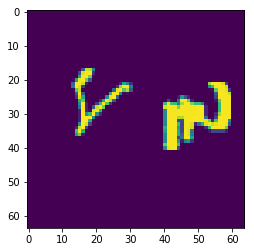

In [81]:
import matplotlib.pyplot as plt
plt.imshow(data_set[100][0])

In [78]:
data_set=data_set/255

In [80]:
np.max(data_set)

1.0

### Create training set: X

In [82]:
past=10 #how far into the past we are looking
input_data=np.zeros((len(data_set)-past-1,past,data_set.shape[2],data_set.shape[3],1))

for i in range(past,len(data_set)-1):
    input_data[i-past,:,:,:,0]=data_set[i-past:i,0,:,:]

In [83]:
input_data.shape

(9989, 10, 64, 64, 1)

### Create training set: Y

In [84]:
y_train=data_set[past+1:]

In [85]:
y_train.shape

(9989, 1, 64, 64)

In [86]:
y_train=y_train.reshape(y_train.shape[0],1,y_train.shape[2],y_train.shape[3],1)

In [87]:
y_train.shape

(9989, 1, 64, 64, 1)

## Model 

In [68]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import pylab as plt

In [88]:
seq = Sequential()
seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   input_shape=(None, 64, 64, 1),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True))
seq.add(BatchNormalization())

#seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                   padding='same', return_sequences=True))
#seq.add(BatchNormalization())
#
#seq.add(ConvLSTM2D(filters=40, kernel_size=(3, 3),
#                   padding='same', return_sequences=True))
#seq.add(BatchNormalization())

seq.add(Conv3D(filters=1, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last'))
seq.compile(loss='binary_crossentropy', optimizer='adadelta',metrics=['accuracy'])

In [89]:
seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_7 (ConvLSTM2D)  (None, None, 64, 64, 40)  59200     
_________________________________________________________________
batch_normalization_7 (Batch (None, None, 64, 64, 40)  160       
_________________________________________________________________
conv_lst_m2d_8 (ConvLSTM2D)  (None, None, 64, 64, 40)  115360    
_________________________________________________________________
batch_normalization_8 (Batch (None, None, 64, 64, 40)  160       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, None, 64, 64, 1)   1081      
Total params: 175,961
Trainable params: 175,801
Non-trainable params: 160
_________________________________________________________________


In [ ]:
seq.fit(input_data, y_train, batch_size=10,
        epochs=30, validation_split=0.05)

Train on 9489 samples, validate on 500 samples
Epoch 1/30
3860/9489 [===========>..................] - ETA: 1:43:07 - loss: 0.2316 - acc: 0.9006